In [12]:
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [2]:
# Basics
import tensorflow as tf
import pandas as pd
import xarray as xr

# Helpful
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt

# My Methods
from src.utils.CRPS import *  # CRPS metrics
from src.utils.data_split import *  # Splitting data into X and y
from src.utils.drn_make_X_array import *  # Import make train array functions (make_X_array)
from src.models.EMOS import *  # EMOS implementation
from src.models.DRN.DRN_model import *  # DRN implementation
from src.models.DRN.DRN_load_score import *  # Load DRN_scores
from src.models.DRN.DRN_load_model import *  # Load Models
from src.models.DRN.DRN_train import *
from src.models.EMOS_local.EMOS_local_load_score import *  # Load EMOS_local_scores
from src.models.EMOS_global.EMOS_global_load_score import *  # Load EMOS_global_scores
from src.models.EMOS_global.EMOS_global_load_model import *  # Load EMOS_global_models#
import data.raw.load_data_raw as ldr  # Load raw data
import data.processed.load_data_processed as ldp  # Load processed data normed
import data.processed.load_data_processed_denormed as ldpd  # Load processed data denormed
from src.models.CRPS_baseline.CRPS_load import *  # Load CRPS scores

2023-06-18 19:20:31.933952: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/anaconda3/lib/
2023-06-18 19:20:31.933972: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


<IPython.core.display.Javascript object>

### 1. Load CRPS scores

In [6]:
# Baseline Scores
CRPS_baseline_scores_test_ws10 = crps_load_lead_lat_lon("ws10")
CRPS_baseline_scores_val_ws10 = crps_load_lead_lat_lon_val("ws10")
CRPS_baseline_scores_train_ws10 = crps_load_lead_lat_lon_train("ws10")

# Just to test add t2m
CRPS_baseline_scores_test_t2m = crps_load_lead_lat_lon("t2m")
CRPS_baseline_scores_val_t2m = crps_load_lead_lat_lon_val("t2m")

<IPython.core.display.Javascript object>

### 2. Comparison Val and Test scores

In [8]:
for i in range(31):
    print(f"Train scores: {CRPS_baseline_scores_train_ws10[i].mean()} in lead {i}")
    print(f"Val scores: {CRPS_baseline_scores_val_ws10[i].mean()} in lead {i}")
    print(f"Test scores: {CRPS_baseline_scores_test_ws10[i].mean()} in lead {i}")
    print(
        f"Difference Test - Val {CRPS_baseline_scores_val_ws10[i].mean() - CRPS_baseline_scores_test_ws10[i].mean()} in lead {i}"
    )
    print("")

Train scores: 0.6603173613548279 in lead 0
Val scores: 0.6658014059066772 in lead 0
Test scores: 0.4708288311958313 in lead 0
Difference Test - Val 0.19497257471084595 in lead 0

Train scores: 0.7574978470802307 in lead 1
Val scores: 0.7732185125350952 in lead 1
Test scores: 0.5626273155212402 in lead 1
Difference Test - Val 0.21059119701385498 in lead 1

Train scores: 0.8004212379455566 in lead 2
Val scores: 0.8087474703788757 in lead 2
Test scores: 0.5660684704780579 in lead 2
Difference Test - Val 0.24267899990081787 in lead 2

Train scores: 0.8202793002128601 in lead 3
Val scores: 0.8332287073135376 in lead 3
Test scores: 0.6244665384292603 in lead 3
Difference Test - Val 0.20876216888427734 in lead 3

Train scores: 0.839388370513916 in lead 4
Val scores: 0.841774582862854 in lead 4
Test scores: 0.6273626685142517 in lead 4
Difference Test - Val 0.2144119143486023 in lead 4

Train scores: 0.8983346819877625 in lead 5
Val scores: 0.9103854894638062 in lead 5
Test scores: 0.741938531

<IPython.core.display.Javascript object>

In [9]:
for i in range(31):
    print(f"Val scores: {CRPS_baseline_scores_val_t2m[i].mean()} in lead {i}")
    print(f"Test scores: {CRPS_baseline_scores_test_t2m[i].mean()} in lead {i}")
    print(
        f"Difference Test - Val {CRPS_baseline_scores_val_t2m[i].mean() - CRPS_baseline_scores_test_t2m[i].mean()} in lead {i}"
    )
    print("")

Val scores: 0.5012174149060862 in lead 0
Test scores: 0.5084816639136492 in lead 0
Difference Test - Val -0.007264249007563062 in lead 0

Val scores: 0.5049655545333702 in lead 1
Test scores: 0.5347707002046389 in lead 1
Difference Test - Val -0.029805145671268685 in lead 1

Val scores: 0.49082135951235406 in lead 2
Test scores: 0.5150757989800734 in lead 2
Difference Test - Val -0.024254439467719324 in lead 2

Val scores: 0.5218363688739838 in lead 3
Test scores: 0.5301602687833538 in lead 3
Difference Test - Val -0.008323899909369992 in lead 3

Val scores: 0.5450302728645224 in lead 4
Test scores: 0.5624034501418446 in lead 4
Difference Test - Val -0.017373177277322127 in lead 4

Val scores: 0.5928348029515252 in lead 5
Test scores: 0.6306282599852645 in lead 5
Difference Test - Val -0.037793457033739264 in lead 5

Val scores: 0.5948379144402783 in lead 6
Test scores: 0.6316119778923832 in lead 6
Difference Test - Val -0.03677406345210488 in lead 6

Val scores: 0.6225855392322349 in 

<IPython.core.display.Javascript object>

### On a heatmap

In [17]:
def heatmap_lead(var_name, lead_time, models=[True, True, True]):
    """
    Plots the specified number of heatmaps of the scores for a specified lead time
    Args:
        var_name (str): variable to use 
        lead_time (int): Lead time 0 - 30
        models (list): Boolean list determining which models to plot
    Returns:
        None
    """
    # Load lead_time specific scores
    load_funcs = [
        crps_load_lead_lat_lon_train,
        crps_load_lead_lat_lon_val,
        crps_load_lead_lat_lon,
    ]
    all_mean_scores = []
    for count, boolean in enumerate(models):
        if boolean:
            all_mean_scores.append(load_funcs[count](var_name)[lead_time])

    # Determine the global minimum and maximum
    min_val = np.min([np.min(scores) for scores in all_mean_scores])
    max_val = np.max([np.max(scores) for scores in all_mean_scores])

    # Decide on labels
    labels_all = ["CRPS_train_baseline", "CRPS_val_baseline", "CRPS_test_baseline"]
    labels_models = []
    for count, boolean in enumerate(models):
        if boolean:
            labels_models.append(labels_all[count])

    # Plot heat maps
    fig, axs = plt.subplots(len(all_mean_scores), 1, figsize=(25, 15))
    for model in range(len(all_mean_scores)):
        im = axs[model].imshow(all_mean_scores[model], cmap="viridis")
        im.set_clim(min_val, max_val)  # Set the same color limits for each heatmap
        fig.colorbar(
            im, ax=axs[model], label="your label"
        )  # add colorbar to the figure and associate it with the axis
        axs[model].set_title(
            f"Colormap {labels_models[model]} score, lead_time {lead_time}"
        )
    plt.show()


<IPython.core.display.Javascript object>

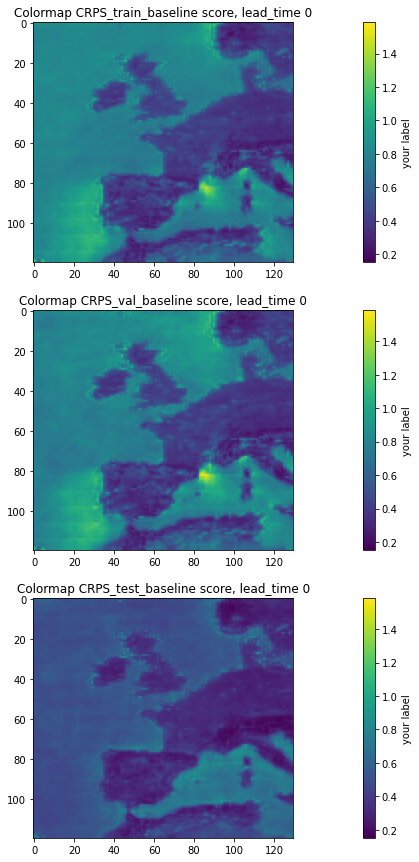

<IPython.core.display.Javascript object>

In [18]:
heatmap_lead("ws10", 0, models=[True, True, True])